In [98]:
# Opción para python 3.12 [gráficos de plotly en notebook]
import plotly.offline as pyo
import plotly.graph_objs as go

# Set notebook mode to work in offline
pyo.init_notebook_mode()

In this document, I will fit several linear regression models to the housing sales data. To do this, I’ll use the dataset generated after the cleaning process, ensuring that the data is “clean” and free from certain risks.

First, I’ll load the file created during the data cleaning step. It’s important to note that this process could be repeated using different variable preprocessing strategies. For instance, I could try applying winsorization and random imputations, and then compare the results with other approaches — such as removing outliers and missing values, or converting outliers into missing values and imputing them using multivariate models. There’s a whole world of possibilities to explore!

In [101]:
import pandas as pd
import numpy as np

# Warning Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Import my functions
# ==============================================================================
execfile(r'NuestrasFunciones.py')

# Read cleaned data
housesDep = pd.read_hdf(r'Data_houses_wins_itImp_mode.h5')

housesDep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4998
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   month          4999 non-null   float64 
 1   bathrooms      4999 non-null   float64 
 2   sqft_living    4999 non-null   float64 
 3   sqft_above     4999 non-null   float64 
 4   yr_built       4999 non-null   float64 
 5   lat            4999 non-null   float64 
 6   long           4999 non-null   float64 
 7   bedrooms_cont  4999 non-null   float64 
 8   log_sqft_lot   4999 non-null   float64 
 9   prop_missings  4999 non-null   float64 
 10  year           4999 non-null   category
 11  floors         4999 non-null   category
 12  waterfront     4999 non-null   category
 13  view           4999 non-null   category
 14  condition      4999 non-null   category
 15  basement       4999 non-null   category
 16  yr_renovated   4999 non-null   category
 17  bedrooms_cat   4999 non-null   categor

In [103]:
# We'll convert "prop_missings" variable to numeric (continuos variable)
housesDep['prop_missings'] = housesDep['prop_missings'].astype('float64')

In [105]:
housesDep.describe().round(2)

month  bathrooms  sqft_living  sqft_above  yr_built      lat  \
count  4999.00    4999.00      4999.00     4999.00   4999.00  4999.00   
mean      6.59       2.14      2072.80     1782.14   1971.10    47.56   
std       3.12       0.87       893.39      812.22     29.23     0.14   
min       1.00       0.00       370.00      370.00   1900.00    47.16   
25%       4.00       1.50      1410.00     1190.00   1951.00    47.48   
50%       6.00       2.50      1910.00     1550.00   1975.00    47.57   
75%       9.00       2.50      2560.00     2220.00   1996.00    47.68   
max      12.00       6.00      6110.00     5400.00   2015.00    47.78   

          long  bedrooms_cont  log_sqft_lot  prop_missings       price  
count  4999.00        4999.00       4999.00        4999.00     4999.00  
mean   -122.21           3.36          8.98           0.61   543577.82  
std       0.14           0.90          0.84           1.84   370981.42  
min    -122.50           0.00          6.46           0.00    86500.00  
25%    -122.33           3.00          8.54           0.00   324925.00  
50%    -122.23           3.00          8.94           0.00   451000.00  
75%    -122.12           4.00          9.29           0.00   645000.00  
max    -121.47           8.00         11.73          11.76  7062500.00

In [107]:
housesDep.describe(exclude = np.number)

year floors waterfront  view condition basement yr_renovated  \
count   4999   4999       4999  4999      4999     4999         4999   
unique     2      5          2     2         4        2            2   
top     2014    1.0          0     0         B        0            0   
freq    3415   2463       4957  4508      3254     3044         4783   

       bedrooms_cat  Luxury  
count          4999    4999  
unique            7       2  
top               3       0  
freq           2233    2886

## Descriptive Analysis. Relationships between variables and the target variable

In this section, I’ll explore the marginal relationships between the variables and the target variable to get an initial idea of which ones are likely to be influential in the regression models I’ll be fitting. I will generate pairwise plots between the target variable, price (log-transformed due to its large range between minimum and maximum), and the predictor variables. First, I'm crossing price and log_price to see the differences.

In [111]:
housesDep['log_price'] = np.log(housesDep['price'])

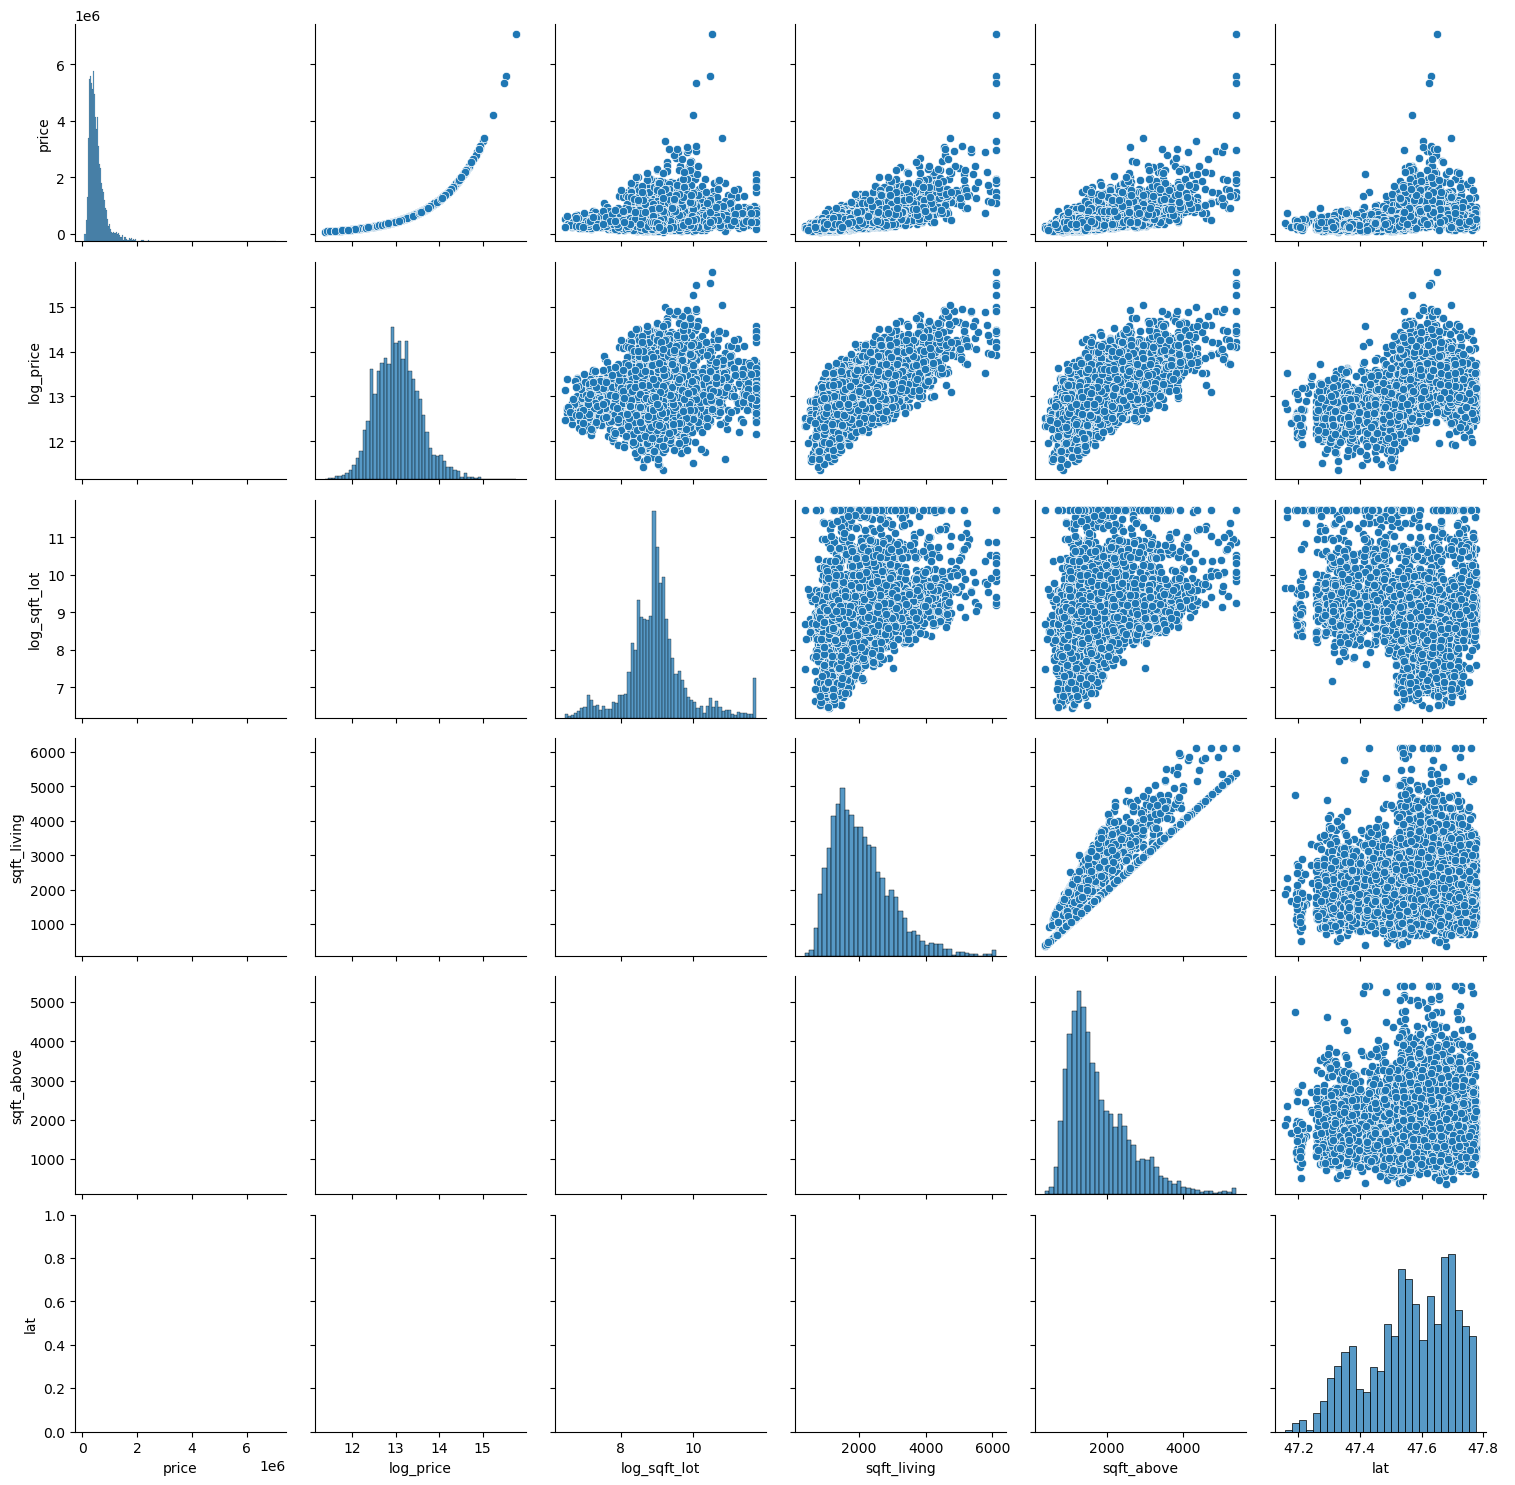

In [113]:
import seaborn as sns
 

g = sns.PairGrid(housesDep[['price','log_price','log_sqft_lot','sqft_living','sqft_above','lat']])
g.map_diag(sns.histplot)
#g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.add_legend()
# # 
plt.show()

Apparently there's no any clear pattern in price-sqft_lot. If I had to choose what sqft variable to use, I'd go with the sqft_living. For log_price - log_sqft_lot, since they both have been transformed in log, there's no lineal relationship. However, log_price - and sqft_living looks better.

For the relationship log_price - lat, it's like an "s" meaning there's no lineality. I'll try to bin it in 2 binnings.

For sqft_living and sqft_above, I’ll need to choose which one to include in the model — I can’t use both at the same time due to perfect collinearity.

To sum up:
- log_price and sqft_living and sqft_above look good (linearity)
- log_price and lat: I'll do 2 binnings
- sqft_living - sqft_above: perfect collinearity = problem!

## Generate random variables and drop target variables

I'll generate random variable to control for spurious effects in the model

In [118]:
housesDep['random'] = np.random.uniform(0,1,size=housesDep.shape[0])
housesDep['random2'] = np.random.uniform(0,1,size=housesDep.shape[0])
housesDep.head()

month  bathrooms  sqft_living  sqft_above  yr_built      lat     long  \
0    7.0        2.5       2070.0      1540.0    1980.0  47.5936 -122.013   
1    6.0        1.5       1640.0      1540.0    1916.0  47.6624 -122.325   
2   10.0        3.5       3720.0      3720.0    2007.0  47.3216 -121.940   
3   12.0        3.5       2260.0      1880.0    2003.0  47.6422 -122.361   
4   10.0        2.0       2050.0      1170.0    1960.0  47.7447 -122.328   

   bedrooms_cont  log_sqft_lot  prop_missings  ... view condition basement  \
0            3.0      9.301094       5.882353  ...    0        CD        1   
1            2.0      9.053580       5.882353  ...    0         A        1   
2            4.0     10.139560       5.882353  ...    1         B        0   
3            3.0      8.218188       5.882353  ...    0         B        1   
4            3.0      8.650238       5.882353  ...    0         A        1   

  yr_renovated bedrooms_cat   price Luxury  log_price    random   random2  
0            0            3  653450      1  13.390021  0.448262  0.254701  
1            0            2  710000      1  13.473020  0.478363  0.658395  
2            0            4  780000      1  13.567049  0.093136  0.794153  
3            0            3  795000      1  13.586097  0.955884  0.485899  
4            0            3  399950      0  12.899095  0.687033  0.946232  

[5 rows x 23 columns]

In [119]:
# I'll drop price, log_price and luxury variables
varObjCont = housesDep.price
varObjCont_log = housesDep.log_price
imput = housesDep.drop(['price','log_price','Luxury'],axis=1)
imput.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4998
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   month          4999 non-null   float64 
 1   bathrooms      4999 non-null   float64 
 2   sqft_living    4999 non-null   float64 
 3   sqft_above     4999 non-null   float64 
 4   yr_built       4999 non-null   float64 
 5   lat            4999 non-null   float64 
 6   long           4999 non-null   float64 
 7   bedrooms_cont  4999 non-null   float64 
 8   log_sqft_lot   4999 non-null   float64 
 9   prop_missings  4999 non-null   float64 
 10  year           4999 non-null   category
 11  floors         4999 non-null   category
 12  waterfront     4999 non-null   category
 13  view           4999 non-null   category
 14  condition      4999 non-null   category
 15  basement       4999 non-null   category
 16  yr_renovated   4999 non-null   category
 17  bedrooms_cat   4999 non-null   categor

## V-Cramer Ranking

Therefore, whether during the initial inspection of relationships with the target variable —using correlation (for linear relationships between continuous variables) or Cramér’s V (to assess associations in contingency tables between categorical variables or binned continuous ones)— or within the regression models themselves, I will pay close attention to variables that show a weaker relationship with the target than the random control variable. If a variable performs worse than random noise, it raises doubts about the validity of its relationship with the outcome. In those cases, I’ll likely discard it from the model, at least in its current form — though I can always consider transforming or binning it to explore alternative representations.

In [125]:
# I'll apply Cramer to the imput
Cramertable = pd.DataFrame(imput.apply(lambda x: cramers_v(x,varObjCont_log)),columns=['VCramer'])
Cramertable.sort_values(by='VCramer', ascending=False)


VCramer
sqft_living    0.392472
view           0.352998
bathrooms      0.333261
sqft_above     0.321706
lat            0.254993
waterfront     0.246556
basement       0.216859
bedrooms_cat   0.189062
bedrooms_cont  0.184368
floors         0.165582
log_sqft_lot   0.119279
yr_built       0.109701
yr_renovated   0.108071
long           0.084486
condition      0.074406
random2        0.030657
month          0.028217
random         0.024814
year           0.021998
prop_missings  0.017754

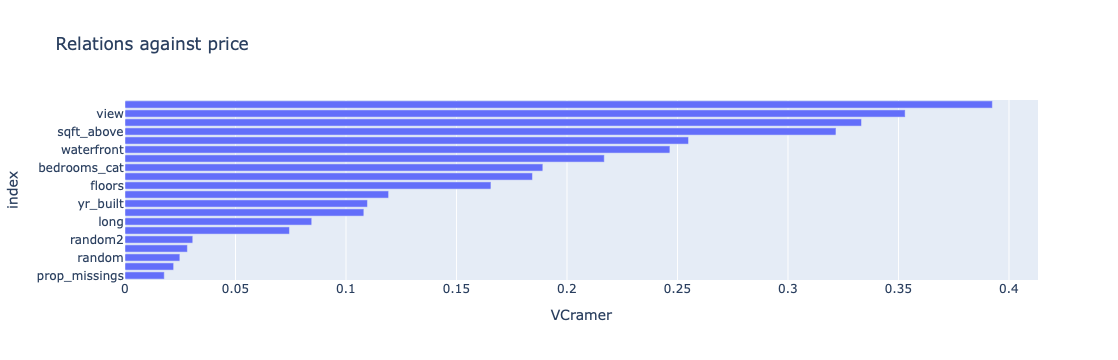

In [127]:
import plotly.express as px
px.bar(Cramertable,x=Cramertable.VCramer,title='Relations against price').update_yaxes(categoryorder="total ascending")
#plt.show()

Everything seems to be in good shape, and for now, I won’t include the variables year and month in the model. However, they might become relevant in a different modeling approach later on. I’ll generate the correlation matrix to see how the **numeric variables** are correlated.

In [130]:
corr = housesDep.select_dtypes(include=np.number).corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

There is a almost perfect correlation between sqft_above and sqft_living

## Binning for "lat"

Another approach worth exploring is transforming continuous variables into categorical ones (binning) to uncover non-linear patterns that may otherwise go unnoticed. There are two main binning strategies:

1. Ad-hoc bins for interpretability: These are typically based on predefined or meaningful intervals, such as age groups commonly used in official statistics. They often follow equal-width or concept-driven rules to improve interpretability.
   
2. Optimal bins based on the target variable: In this approach, breakpoints are selected to maximize the difference in the target variable across bins. This can enhance the variable’s predictive power. A common method is to use decision trees, which split variables in a way that best separates the outcome—exactly what we're looking for. However, this method carries the risk of overfitting if applied directly to the training data.


**"Lat" variable**

Using more bins could be interesting and might increase the model’s predictive power, but it could also make the model too complex and lead to overfitting. The best decision here is to use two bins for “lat”. I’ll use decision trees to bin the “lat” variable. 

I'm running a code to see where to cut but first I'll check the "lat" variable:


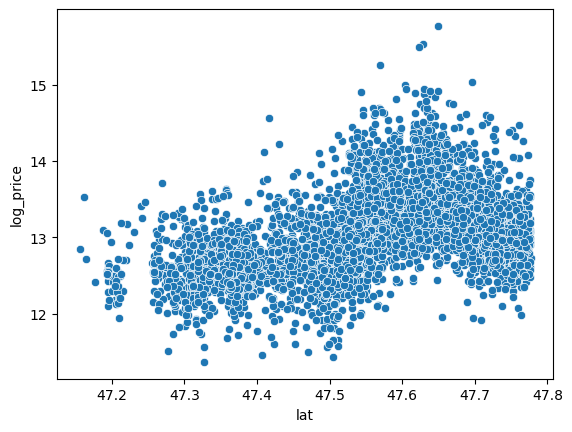

In [136]:
plt.clf()
sns.scatterplot(data=housesDep, x="lat", y="log_price")
#sns.boxplot(x='sqft_living',y='Luxury',data=viviendasDep,palette='viridis')
plt.show()

In [138]:
# http://gnpalencia.org/optbinning/binning_continuous.html
from optbinning import ContinuousOptimalBinning

optb = ContinuousOptimalBinning(name='lat', dtype="numerical", max_n_bins=2)
optb.fit(imput['lat'].values, np.log(varObjCont))

x_transform_bins = optb.transform(imput['lat'].values, metric="bins")
x_transform_bins

array(['[47.51, inf)', '[47.51, inf)', '(-inf, 47.51)', ...,
       '(-inf, 47.51)', '[47.51, inf)', '[47.51, inf)'], dtype=object)

We'll cut in 47.51. I am also running a parallel violin plot with the variable "lat" binned in two gropus cut on 47.51. Here we have the distributions:

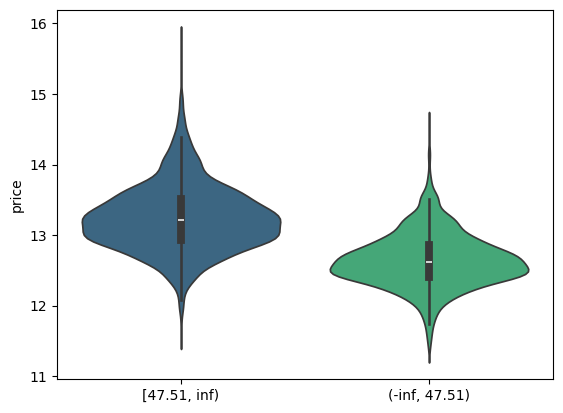

In [141]:
plt.clf()
sns.violinplot(x=x_transform_bins,y=np.log(varObjCont),palette='viridis')
plt.show()

Now that we have 2 different variables for lat, I can run 2 different models but I'll do first with the regular lat variable against log(price)

In [144]:
# Linear Regression model  with lat
from statsmodels.formula.api import ols 
from sklearn.model_selection import train_test_split
model = ols('np.log(price) ~ lat', data=housesDep).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     1218.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):          5.74e-239
Time:                        17:23:36   Log-Likelihood:                -3346.9
No. Observations:                4999   AIC:                             6698.
Df Residuals:                    4997   BIC:                             6711.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -67.2353      2.301    -29.223      0.000     -71.746     -62.725
lat            1.6881      0.048     34.897      0.000       1.593       1.783
==============================================================================
Omnibus:                      379.657   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              574.932
Skew:                           0.605   Prob(JB):                    1.43e-125
Kurtosis:                       4.138   Cond. No.                     1.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
tr_tst_eval_lin('log_price ~ lat',housesDep)

Coeficiente de determinación TRAINING:  0.19805928428092423 

Root Mean squared error TEST: 0.47
Coeficiente de determinación TEST: 0.19


We see that "lat" is significative with 0 p-values with a ß of 1.68. The R2 for this model is 0.196. Now I'll check with lat_rec

In [149]:
# Linear Regression model  with lat_rec
housesDep['lat_rec'] = x_transform_bins
model = ols('np.log(price) ~ C(lat_rec)', data=housesDep).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     1936.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:23:43   Log-Likelihood:                -3073.5
No. Observations:                4999   AIC:                             6151.
Df Residuals:                    4997   BIC:                             6164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     12.6411      0.011   1116.973      0.000      12.619      12.663
C(lat_rec)[T.[47.51, inf)]     0.6008      0.014     44.003      0.000       0.574       0.628
==============================================================================
Omnibus:                      366.141   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              615.092
Skew:                           0.554   Prob(JB):                    2.72e-134
Kurtosis:                       4.314   Cond. No.                         3.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
tr_tst_eval_lin('log_price ~ C(lat_rec)',housesDep)

Coeficiente de determinación TRAINING:  0.28280010064673566 

Root Mean squared error TEST: 0.44
Coeficiente de determinación TEST: 0.26


The R2 for this model has increased up to 0.279, much better so I'll use the binning of lat instead because the model is better. This means that from now on I'll have to boroughs based on latitude (lat). If we go from the borough 1 to the borough 2, this will make the price increase in 60%. 

## Linear Regression Models for housing price prediction

In this section, I will fit several linear regression models to predict housing prices. First, I’ll split the data into a training set (where I fit the model) and a test set (where I evaluate its performance).

### Training-Test Partition

First, I’ll split the data into a training set (where I fit the model) and a test set (where I evaluate its performance). I'll have a matrix with the different X variables (predictors) and the target variable vector. With train_test_split(), I'll have those ones separately.

In [308]:
imput['lat_rec'] = x_transform_bins

# varObjCont_log = np.log(varObjCont)
# varObjCont_log.name='log_price'

# Function:
from sklearn.model_selection import train_test_split

# Creating 4 objects: predictors for tr and tst, and target variable for tr and tst
X_train, X_test, y_train, y_test = train_test_split(imput, varObjCont_log, test_size=0.20, random_state=42)

# I'm checking dimensions
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (3999, 21) (3999,)
Testing dataset shape: (1000, 21) (1000,)


In [310]:
# I generate the training dataset with the target variable in it
data_train = X_train.join(y_train)
data_train.columns

Index(['month', 'bathrooms', 'sqft_living', 'sqft_above', 'yr_built', 'lat',
       'long', 'bedrooms_cont', 'log_sqft_lot', 'prop_missings', 'year',
       'floors', 'waterfront', 'view', 'condition', 'basement', 'yr_renovated',
       'bedrooms_cat', 'random', 'random2', 'lat_rec', 'log_price'],
      dtype='object')

In [311]:
# This is the predictor matrix
X_train.head()

month  bathrooms  sqft_living  sqft_above  yr_built      lat     long  \
1738    8.0        1.0       1240.0      1240.0    1953.0  47.4927 -122.169   
4943    2.0        3.0       2580.0      2130.0    1992.0  47.3726 -122.433   
2916   10.0        2.5       2100.0      2100.0    1914.0  47.4787 -122.230   
1595    9.0        1.0        910.0       910.0    1969.0  47.3405 -122.288   
3214   12.0        2.0       1610.0      1610.0    1968.0  47.7270 -122.176   

      bedrooms_cont  log_sqft_lot  prop_missings  ... floors waterfront view  \
1738            3.0      8.648221            0.0  ...    1.5          0    0   
4943            4.0      9.169623            0.0  ...    2.0          0    0   
2916            4.0      9.887358            0.0  ...    1.5          0    0   
1595            3.0      8.947156            0.0  ...    1.0          0    0   
3214            4.0      9.333000            0.0  ...    1.0          0    0   

     condition basement yr_renovated bedrooms_cat    random   random2  \
1738         A        0            0            3  0.382969  0.849155   
4943        CD        1            0            4  0.025524  0.242192   
2916         B        0            0            4  0.163865  0.228082   
1595         B        0            0            3  0.426251  0.572655   
3214         B        0            0            4  0.932676  0.825026   

            lat_rec  
1738  (-inf, 47.51)  
4943  (-inf, 47.51)  
2916  (-inf, 47.51)  
1595  (-inf, 47.51)  
3214   [47.51, inf)  

[5 rows x 21 columns]

In [312]:
# This is the target variable vector
y_train.head()

1738    12.380026
4943    12.779873
2916    12.240474
1595    12.037654
3214    12.823957
Name: log_price, dtype: float64

### Colinearity of the sqft

Since we had the problem with sqft_living and sqft_above, I will run a model for sqft_living, a model for sqft_above and will see which one predicts better (higher R2):

In [315]:
# Linear Reg Model for sqft_living
from statsmodels.formula.api import ols 

results = ols('log_price ~ sqft_living',data=housesDep).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     4973.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:35   Log-Likelihood:                -2165.6
No. Observations:                4999   AIC:                             4335.
Df Residuals:                    4997   BIC:                             4348.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.1902      0.013    913.920      0.000      12.164      12.216
sqft_living     0.0004   5.91e-06     70.517      0.000       0.000       0.000
==============================================================================
Omnibus:                       13.965   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.365
Skew:                           0.030   Prob(JB):                      0.00340
Kurtosis:                       2.774   Cond. No.                     5.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [316]:
tr_tst_eval_lin('log_price ~ sqft_living',housesDep)

Coeficiente de determinación TRAINING:  0.5047699547470573 

Root Mean squared error TEST: 0.38
Coeficiente de determinación TEST: 0.47


In [317]:
# Linear Reg Model for sqft_above
from statsmodels.formula.api import ols 

results = ols('log_price ~ sqft_above',data=housesDep).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     2848.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:35   Log-Likelihood:                -2764.8
No. Observations:                4999   AIC:                             5534.
Df Residuals:                    4997   BIC:                             5547.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3571      0.014    861.040      0.000      12.329      12.385
sqft_above     0.0004   7.33e-06     53.362      0.000       0.000       0.000
==============================================================================
Omnibus:                       24.380   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.947
Skew:                           0.152   Prob(JB):                     6.31e-06
Kurtosis:                       2.849   Cond. No.                     4.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [318]:
tr_tst_eval_lin('log_price ~ sqft_above',housesDep)

Coeficiente de determinación TRAINING:  0.36756464018020985 

Root Mean squared error TEST: 0.42
Coeficiente de determinación TEST: 0.34


We see that sqft_living explains more of the variability of the model (0.499 vs 0.363 for sqft_above). I'll check what the variability is  (total R2) for sqft_above + sqft_living so I'll run a model with both variables:

In [320]:
# Linear Reg Model for sqft_living and sqft_above
from statsmodels.formula.api import ols 

# Ajusto regresión de ejemplo
results = ols('log_price ~ sqft_living+sqft_above',data=housesDep).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     2496.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:36   Log-Likelihood:                -2160.3
No. Observations:                4999   AIC:                             4327.
Df Residuals:                    4996   BIC:                             4346.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.1960      0.013    907.200      0.000      12.170      12.222
sqft_living     0.0005   1.22e-05     36.973      0.000       0.000       0.000
sqft_above  -4.393e-05   1.34e-05     -3.269      0.001   -7.03e-05   -1.76e-05
==============================================================================
Omnibus:                       10.124   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                8.594
Skew:                           0.030   Prob(JB):                       0.0136
Kurtosis:                       2.806   Cond. No.                     7.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [321]:
tr_tst_eval_lin('log_price ~ sqft_living + sqft_above',housesDep)

Coeficiente de determinación TRAINING:  0.5059042800706688 

Root Mean squared error TEST: 0.38
Coeficiente de determinación TEST: 0.47


We see that if we include both variables, R2 is 0.50 whereas it just was 0.499 with sqft_living. I won't use sqft_above in my model because R2 doesn't increase if we add that and that would mean multicolinearity (the had 0.875 in the VCramer)...


To fully rule one of them out, I can check for an interaction between the two variables — that is, assess the main effect of each one separately and then include their interaction term. If neither the individual effects nor the interaction contribute meaningfully to the model, it would be reasonable to exclude one of them.

In [324]:
# Linear Reg Model for the effects of sqft_living and sqft_above (interaction)
from statsmodels.formula.api import ols 

# Ajusto regresión de ejemplo
results = ols('log_price ~ sqft_living*sqft_above',data=housesDep).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     1664.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:36   Log-Likelihood:                -2160.3
No. Observations:                4999   AIC:                             4329.
Df Residuals:                    4995   BIC:                             4355.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 12.2015      0.028    439.449      0.000      12.147      12.256
sqft_living                0.0004   1.54e-05     29.111      0.000       0.000       0.000
sqft_above             -4.731e-05      2e-05     -2.366      0.018   -8.65e-05    -8.1e-06
sqft_living:sqft_above  1.141e-09   5.01e-09      0.228      0.820   -8.67e-09     1.1e-08
==============================================================================
Omnibus:                        9.918   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                8.436
Skew:                           0.029   Prob(JB):                       0.0147
Kurtosis:                       2.807   Cond. No.                     3.14e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the p-value for the interaction (sqft_living:sqft_above) is 0.82 (much higher than 0.05) so this is not significant. Conclusion: I'll just take sqft_living and will forget sqft_above 

### Simple Linear Regression Model 

In [327]:
# Model with sqft_living + lat_rec
from statsmodels.formula.api import ols 

# Ajusto regresión de ejemplo
results = ols('log_price ~ sqft_living+lat_rec',data=housesDep).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     5924.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:36   Log-Likelihood:                -854.19
No. Observations:                4999   AIC:                             1714.
Df Residuals:                    4996   BIC:                             1734.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.8968      0.011   1042.350      0.000      11.874      11.919
lat_rec[T.[47.51, inf)]     0.5175      0.009     58.710      0.000       0.500       0.535
sqft_living                 0.0004   4.58e-06     84.524      0.000       0.000       0.000
==============================================================================
Omnibus:                      137.571   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.797
Skew:                           0.184   Prob(JB):                     5.79e-60
Kurtosis:                       4.083   Cond. No.                     6.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [328]:
tr_tst_eval_lin('log_price ~ sqft_living + lat_rec',housesDep)

Coeficiente de determinación TRAINING:  0.7076315723353972 

Root Mean squared error TEST: 0.29
Coeficiente de determinación TEST: 0.69


### Linear Regression Models

**IMPORTANT**

We have duplicate variables (e.g., lat and lat_rec, and bedrooms_cat and bedrooms_cont). I will remove lat and bedrooms_cat from the general regression model. I’ve chosen to keep bedrooms_cont over bedrooms_cat to avoid adding unnecessary complexity to the model.

I’ll run a general linear regression model with all the remaining variables to see what the maximum R² looks like. Then, I will be deleting one by one without separating to the R²


In [331]:
data_train.columns

Index(['month', 'bathrooms', 'sqft_living', 'sqft_above', 'yr_built', 'lat',
       'long', 'bedrooms_cont', 'log_sqft_lot', 'prop_missings', 'year',
       'floors', 'waterfront', 'view', 'condition', 'basement', 'yr_renovated',
       'bedrooms_cat', 'random', 'random2', 'lat_rec', 'log_price'],
      dtype='object')

In [332]:
form=ols_formula(data_train,'log_price', 'bedrooms_cat','lat')
form


'log_price ~ month + bathrooms + sqft_living + sqft_above + yr_built + long + bedrooms_cont + log_sqft_lot + prop_missings + year + floors + waterfront + view + condition + basement + yr_renovated + random + random2 + lat_rec'

In [333]:
# General Regression Model
modeloC = ols(form,data=housesDep).fit()
modeloC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     640.6
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:36   Log-Likelihood:                -370.76
No. Observations:                4999   AIC:                             791.5
Df Residuals:                    4974   BIC:                             954.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -11.6103      4.184     -2.775      0.006     -19.813      -3.408
year[T.2015]                0.0479      0.013      3.790      0.000       0.023       0.073
floors[T.1.5]               0.0478      0.015      3.272      0.001       0.019       0.076
floors[T.2.0]               0.0268      0.012      2.180      0.029       0.003       0.051
floors[T.2.5]               0.1207      0.045      2.698      0.007       0.033       0.208
floors[T.3.0]               0.1070      0.026      4.053      0.000       0.055       0.159
waterfront[T.1]             0.4215      0.043      9.875      0.000       0.338       0.505
view[T.1]                   0.2024      0.014     14.544      0.000       0.175       0.230
condition[T.B]             -0.1098      0.015     -7.424      0.000      -0.139      -0.081
condition[T.CD]            -0.0513      0.015     -3.414      0.001      -0.081      -0.022
condition[T.Unknown]       -0.2670      0.044     -6.124      0.000      -0.352      -0.182
basement[T.1]               0.0653      0.015      4.401      0.000       0.036       0.094
yr_renovated[T.1]           0.0686      0.020      3.484      0.000       0.030       0.107
lat_rec[T.[47.51, inf)]     0.5090      0.009     58.085      0.000       0.492       0.526
month                      -0.0025      0.002     -1.312      0.190      -0.006       0.001
bathrooms                   0.0566      0.007      8.658      0.000       0.044       0.069
sqft_living                 0.0002   1.73e-05     12.316      0.000       0.000       0.000
sqft_above                  0.0002   1.92e-05      8.447      0.000       0.000       0.000
yr_built                   -0.0009      0.000     -4.221      0.000      -0.001      -0.000
long                       -0.2048      0.033     -6.230      0.000      -0.269      -0.140
bedrooms_cont              -0.0337      0.005     -6.284      0.000      -0.044      -0.023
log_sqft_lot                0.0302      0.006      5.025      0.000       0.018       0.042
prop_missings               0.0015      0.002      0.739      0.460      -0.002       0.005
random                      0.0127      0.013      0.997      0.319      -0.012       0.038
random2                     0.0172      0.013      1.340      0.180      -0.008       0.042
==============================================================================
Omnibus:                      107.633   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.286
Skew:                          -0.072   Prob(JB):                     2.68e-50
Kurtosis:                       4.037   Cond. No.                     3.97e+06
==============================================================================

Notes:
[1] Standard Errors assum

We can see the next variables aren't significant based on their p-values:
- Month
- prop_missings (imputed missings)
- random
- random2
  

In [335]:
tr_tst_eval_lin(form,housesDep)

Coeficiente de determinación TRAINING:  0.7585542597098888 

Root Mean squared error TEST: 0.26
Coeficiente de determinación TEST: 0.74


In order to decide what variable should I include first, I will calculate the relative importance of each one for the model

In [337]:
from relativeImp import relativeImp

# Nombres de las variables continuas
names=X_train.select_dtypes(include=np.number).columns.tolist()

# Calcular importancia relativa de las variable continuas en modelo (solo con variables continuas!)
df_results = relativeImp(data_train, outcomeName = 'log_price', driverNames = names)

df_results.sort_values(by='normRelaImpt', ascending=False)

driver  rawRelaImpt  normRelaImpt
2     sqft_living     0.204473     30.190164
5             lat     0.164353     24.266451
3      sqft_above     0.136396     20.138727
1       bathrooms     0.098588     14.556359
7   bedrooms_cont     0.040799      6.023984
4        yr_built     0.013485      1.991018
8    log_sqft_lot     0.012158      1.795045
6            long     0.005259      0.776537
0           month     0.001622      0.239537
11        random2     0.000109      0.016080
10         random     0.000027      0.003982
9   prop_missings     0.000014      0.002117

I use OLS to have the explicit design matrix, because once I have it, I can discard the model itself.

In [339]:
import patsy

# We generate the design matrices according to the full model formula
y, X = patsy.dmatrices(form, housesDep, return_type='dataframe')

# Now we can apply the official statsmodels OLS function (which takes y and X format)
model=sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     640.6
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:37   Log-Likelihood:                -370.76
No. Observations:                4999   AIC:                             791.5
Df Residuals:                    4974   BIC:                             954.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -11.6103      4.184     -2.775      0.006     -19.813      -3.408
year[T.2015]                0.0479      0.013      3.790      0.000       0.023       0.073
floors[T.1.5]               0.0478      0.015      3.272      0.001       0.019       0.076
floors[T.2.0]               0.0268      0.012      2.180      0.029       0.003       0.051
floors[T.2.5]               0.1207      0.045      2.698      0.007       0.033       0.208
floors[T.3.0]               0.1070      0.026      4.053      0.000       0.055       0.159
waterfront[T.1]             0.4215      0.043      9.875      0.000       0.338       0.505
view[T.1]                   0.2024      0.014     14.544      0.000       0.175       0.230
condition[T.B]             -0.1098      0.015     -7.424      0.000      -0.139      -0.081
condition[T.CD]            -0.0513      0.015     -3.414      0.001      -0.081      -0.022
condition[T.Unknown]       -0.2670      0.044     -6.124      0.000      -0.352      -0.182
basement[T.1]               0.0653      0.015      4.401      0.000       0.036       0.094
yr_renovated[T.1]           0.0686      0.020      3.484      0.000       0.030       0.107
lat_rec[T.[47.51, inf)]     0.5090      0.009     58.085      0.000       0.492       0.526
month                      -0.0025      0.002     -1.312      0.190      -0.006       0.001
bathrooms                   0.0566      0.007      8.658      0.000       0.044       0.069
sqft_living                 0.0002   1.73e-05     12.316      0.000       0.000       0.000
sqft_above                  0.0002   1.92e-05      8.447      0.000       0.000       0.000
yr_built                   -0.0009      0.000     -4.221      0.000      -0.001      -0.000
long                       -0.2048      0.033     -6.230      0.000      -0.269      -0.140
bedrooms_cont              -0.0337      0.005     -6.284      0.000      -0.044      -0.023
log_sqft_lot                0.0302      0.006      5.025      0.000       0.018       0.042
prop_missings               0.0015      0.002      0.739      0.460      -0.002       0.005
random                      0.0127      0.013      0.997      0.319      -0.012       0.038
random2                     0.0172      0.013      1.340      0.180      -0.008       0.042
==============================================================================
Omnibus:                      107.633   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.286
Skew:                          -0.072   Prob(JB):                     2.68e-50
Kurtosis:                       4.037   Cond. No.                     3.97e+06
==============================================================================

Notes:
[1] Standard Errors assum

In [340]:
# Predictor names (in dummy variable format), excluding the intercept
names = X.columns.tolist()[1:]

# We calculate relative importance
df_results = relativeImp(X.join(y), outcomeName = 'log_price', driverNames=names)

# Sort values by normalized relative importance
df_results.sort_values(by='normRelaImpt', ascending=False)


driver  rawRelaImpt  normRelaImpt
12  lat_rec[T.[47.51, inf)]     0.220570     29.192784
15              sqft_living     0.141221     18.690834
16               sqft_above     0.121309     16.055429
14                bathrooms     0.072843      9.640910
6                 view[T.1]     0.046638      6.172592
19            bedrooms_cont     0.032848      4.347479
10            basement[T.1]     0.028566      3.780813
2             floors[T.2.0]     0.027698      3.665902
20             log_sqft_lot     0.016279      2.154531
5           waterfront[T.1]     0.012938      1.712349
17                 yr_built     0.010270      1.359205
18                     long     0.004653      0.615794
11        yr_renovated[T.1]     0.003668      0.485426
4             floors[T.3.0]     0.002881      0.381344
3             floors[T.2.5]     0.002862      0.378815
9      condition[T.Unknown]     0.002698      0.357140
7            condition[T.B]     0.002491      0.329703
1             floors[T.1.5]     0.002142      0.283559
8           condition[T.CD]     0.001237      0.163662
0              year[T.2015]     0.000939      0.124325
13                    month     0.000586      0.077618
23                  random2     0.000140      0.018583
22                   random     0.000051      0.006707
21            prop_missings     0.000034      0.004495

In [341]:
# Relative importance plot based on R² contribution
px.bar(df_results, x='normRelaImpt', y='driver', title='Relative Importance by R² Contribution').update_yaxes(categoryorder="total ascending").show()


I'm using VIF factor to see colinearity:


In [343]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i),2)
                          for i in range(len(X.columns))]
  
print(vif_data)


                    feature         VIF
0                 Intercept  1282141.41
1              year[T.2015]        2.53
2             floors[T.1.5]        1.27
3             floors[T.2.0]        2.62
4             floors[T.2.5]        1.08
5             floors[T.3.0]        1.47
6           waterfront[T.1]        1.11
7                 view[T.1]        1.26
8            condition[T.B]        3.64
9           condition[T.CD]        3.17
10     condition[T.Unknown]        1.10
11            basement[T.1]        3.84
12        yr_renovated[T.1]        1.17
13  lat_rec[T.[47.51, inf)]        1.21
14                    month        2.53
15                bathrooms        2.36
16              sqft_living       17.55
17               sqft_above       17.84
18                 yr_built        2.68
19                     long        1.56
20            bedrooms_cont        1.70
21             log_sqft_lot        1.88
22            prop_missings        1.00
23                   random        1.00


The variables sqft_living and sqft_above exhibit high values and are highly correlated, indicating multicollinearity when both are included in the model. I'll delete sqft_above.

In [345]:
# Apply the full model formula
form_c = ols_formula(data_train, 'log_price', 'lat', 'bedrooms_cat', 'sqft_above')

# Generate design matrices according to the full model formula
y, X = patsy.dmatrices(form_c, housesDep, return_type='dataframe')

# Now we can apply the official statsmodels OLS function (with y, X format)
model_c = sm.OLS(y, X).fit()
model_c.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     656.1
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:37   Log-Likelihood:                -406.36
No. Observations:                4999   AIC:                             860.7
Df Residuals:                    4975   BIC:                             1017.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -11.4999      4.213     -2.729      0.006     -19.760      -3.240
year[T.2015]                0.0462      0.013      3.630      0.000       0.021       0.071
floors[T.1.5]               0.0655      0.015      4.501      0.000       0.037       0.094
floors[T.2.0]               0.0602      0.012      5.127      0.000       0.037       0.083
floors[T.2.5]               0.1734      0.045      3.887      0.000       0.086       0.261
floors[T.3.0]               0.1259      0.026      4.756      0.000       0.074       0.178
waterfront[T.1]             0.4208      0.043      9.789      0.000       0.337       0.505
view[T.1]                   0.1925      0.014     13.783      0.000       0.165       0.220
condition[T.B]             -0.0958      0.015     -6.470      0.000      -0.125      -0.067
condition[T.CD]            -0.0420      0.015     -2.780      0.005      -0.072      -0.012
condition[T.Unknown]       -0.2518      0.044     -5.741      0.000      -0.338      -0.166
basement[T.1]              -0.0323      0.009     -3.440      0.001      -0.051      -0.014
yr_renovated[T.1]           0.0630      0.020      3.178      0.001       0.024       0.102
lat_rec[T.[47.51, inf)]     0.5105      0.009     57.859      0.000       0.493       0.528
month                      -0.0029      0.002     -1.524      0.127      -0.007       0.001
bathrooms                   0.0593      0.007      9.016      0.000       0.046       0.072
sqft_living                 0.0003   7.71e-06     44.739      0.000       0.000       0.000
yr_built                   -0.0008      0.000     -4.043      0.000      -0.001      -0.000
long                       -0.2033      0.033     -6.142      0.000      -0.268      -0.138
bedrooms_cont              -0.0356      0.005     -6.595      0.000      -0.046      -0.025
log_sqft_lot                0.0348      0.006      5.775      0.000       0.023       0.047
prop_missings               0.0014      0.002      0.702      0.483      -0.003       0.005
random                      0.0128      0.013      0.993      0.321      -0.012       0.038
random2                     0.0176      0.013      1.364      0.173      -0.008       0.043
==============================================================================
Omnibus:                      110.293   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.301
Skew:                          -0.078   Prob(JB):                     8.04e-52
Kurtosis:                       4.051   Cond. No.                     3.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number 

Just to make sure, I will calculate the VIF again:

In [347]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i),2)
                          for i in range(len(X.columns))]
  
print(vif_data)


                    feature         VIF
0                 Intercept  1282128.90
1              year[T.2015]        2.53
2             floors[T.1.5]        1.24
3             floors[T.2.0]        2.35
4             floors[T.2.5]        1.06
5             floors[T.3.0]        1.46
6           waterfront[T.1]        1.11
7                 view[T.1]        1.25
8            condition[T.B]        3.60
9           condition[T.CD]        3.16
10     condition[T.Unknown]        1.10
11            basement[T.1]        1.51
12        yr_renovated[T.1]        1.17
13  lat_rec[T.[47.51, inf)]        1.21
14                    month        2.53
15                bathrooms        2.35
16              sqft_living        3.42
17                 yr_built        2.68
18                     long        1.56
19            bedrooms_cont        1.70
20             log_sqft_lot        1.86
21            prop_missings        1.00
22                   random        1.00
23                  random2        1.00


Perfect, there are no values higher than 5.

Now, let's generate a backward elimination process removing variables sequentially based on their p-value.
We first remove aleatorios and prop_missings.

In [349]:
# Backward elimination process of effects based on p-value
form2 = ols_formula(data_train, 'log_price', 'lat', 'bedrooms_cat', 'yr_built',
                    'sqft_above', 'prop_missings', 'random', 'random2',
                    'month', 'basement', 'condition')

# Fit regression without prop_missings
modeloC2 = ols(form2, data=data_train).fit()
modeloC2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     818.5
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        17:27:38   Log-Likelihood:                -386.70
No. Observations:                3999   AIC:                             803.4
Df Residuals:                    3984   BIC:                             897.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -16.8225      4.243     -3.965      0.000     -25.141      -8.504
year[T.2015]                0.0689      0.009      7.579      0.000       0.051       0.087
floors[T.1.5]               0.1071      0.016      6.836      0.000       0.076       0.138
floors[T.2.0]               0.0396      0.011      3.457      0.001       0.017       0.062
floors[T.2.5]               0.1740      0.054      3.252      0.001       0.069       0.279
floors[T.3.0]               0.1027      0.027      3.783      0.000       0.049       0.156
waterfront[T.1]             0.4412      0.049      8.949      0.000       0.345       0.538
view[T.1]                   0.1947      0.016     12.347      0.000       0.164       0.226
yr_renovated[T.1]           0.0802      0.021      3.811      0.000       0.039       0.121
lat_rec[T.[47.51, inf)]     0.5151      0.010     53.157      0.000       0.496       0.534
bathrooms                   0.0456      0.007      6.346      0.000       0.032       0.060
sqft_living                 0.0003   8.47e-06     39.746      0.000       0.000       0.000
long                       -0.2322      0.035     -6.726      0.000      -0.300      -0.165
bedrooms_cont              -0.0281      0.006     -4.610      0.000      -0.040      -0.016
log_sqft_lot                0.0403      0.007      6.067      0.000       0.027       0.053
==============================================================================
Omnibus:                       79.218   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.148
Skew:                          -0.088   Prob(JB):                     7.51e-35
Kurtosis:                       3.955   Cond. No.                     2.26e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cross Validation

In this section, we will evaluate model fitting using repeated cross-validation. The dataset will be split into n_splits partitions, and the process will be repeated n_repeats times with different random seeds. This way, we obtain n_splits × n_repeats models per specified formula, allowing us to average the results over many training-test samples.

In this scheme, all observations in the dataset are used at some point for training to fit the model and at some point for testing to evaluate it, but never simultaneously. Thus, the model is trained and tested on changing subsets, providing robust estimates of its predictive performance.

In [352]:
# Generate design matrices according to the full model formula
y, X = patsy.dmatrices(form2, data_train, return_type='dataframe')

# Get predictor names in dummy format, excluding the intercept
names = X.columns.tolist()[1:]

# Calculate relative importance
df_results = relativeImp(X.join(y), outcomeName='log_price', driverNames=names)

# Sort values by normalized relative importance descending
df_results_sorted = df_results.sort_values(by='normRelaImpt', ascending=False)


After exploring several manual models, it is good practice to evaluate their performance using repeated cross-validation to assess their stability under resampling.

The main goal here is to select the best model considering the bias-variance trade-off and model complexity.

We will create a function to automate the comparison process via cross-validation, allowing it to be applied to any specified formula. Afterwards, we can list all the formulas we want to evaluate and use map() to run the function over them efficiently.

In [354]:
# Define different regression formulas (handling multicollinearity and transformations)
form = ols_formula(data_train, 'log_price', 'lat', 'bedrooms_cat')  # Full model (collinearity in areas!)
form_c = ols_formula(data_train, 'log_price', 'lat', 'bedrooms_cat', 'sqft_above')  # Model without 'sqft_above'

form21 = ols_formula(data_train, 'log_price', 'lat', 'bedrooms_cat',
                     'sqft_above', 'prop_missings', 'random', 'random2',
                     'month', 'basement')  # Backward elimination based on p-values

form4 = ols_formula(data_train, 'log_price', 'lat',
                    'sqft_above', 'prop_missings', 'random', 'random2',
                    'month', 'bedrooms_cont', 'basement', 'floors', 'condition')  # Remove 'condition'

form3 = ols_formula(data_train, 'log_price', 'lat', 'bedrooms_cat',
                    'sqft_above', 'prop_missings', 'random', 'random2',
                    'month', 'bedrooms_cont', 'basement', 'floors')  # Remove 'floors'

form5 = ols_formula(data_train, 'log_price', 'lat', 'bedrooms_cat',
                    'sqft_above', 'prop_missings', 'random', 'random2',
                    'month', 'bedrooms_cont', 'basement', 'floors', 'condition', 'year')  # Remove 'year'

# Alternative formulas with transformations of 'sqft_living' (log-transform)
form6 = 'log_price ~ np.log(sqft_living) + lat_rec + view + waterfront + bedrooms_cont'
form62 = 'log_price ~ np.log(sqft_living) + lat_rec + view + waterfront + bedrooms_cat'

# Initial simple model with 2 variables
form7 = 'log_price ~ sqft_living + lat_rec'

# Create list of formulas
list_form = [form, form_c, form2, form21, form3, form4, form5, form6, form62, form7]

# Apply cross-validation function to all formulas (returns dataframe, transposed)
list_res = pd.DataFrame(map(lambda x: cross_val_lin(x, housesDep, seed=2022), list_form))

# Transpose dataframe and convert from wide to long format for easier analysis
results = list_res.T.melt()
results.columns = ['Model', 'R2']
results.head()


Modelo: log_price ~ month + bathrooms + sqft_living + sqft_above + yr_built + long + bedrooms_cont + log_sqft_lot + prop_missings + year + floors + waterfront + view + condition + basement + yr_renovated + random + random2 + lat_rec
Coeficiente de determinación R2: 0.752 (0.014)
Modelo: log_price ~ month + bathrooms + sqft_living + yr_built + long + bedrooms_cont + log_sqft_lot + prop_missings + year + floors + waterfront + view + condition + basement + yr_renovated + random + random2 + lat_rec
Coeficiente de determinación R2: 0.748 (0.015)
Modelo: log_price ~ bathrooms + sqft_living + long + bedrooms_cont + log_sqft_lot + year + floors + waterfront + view + yr_renovated + lat_rec
Coeficiente de determinación R2: 0.743 (0.015)
Modelo: log_price ~ bathrooms + sqft_living + yr_built + long + bedrooms_cont + log_sqft_lot + year + floors + waterfront + view + condition + yr_renovated + lat_rec
Coeficiente de determinación R2: 0.748 (0.015)
Modelo: log_price ~ bathrooms + sqft_living + yr_b

Model        R2
0      0  0.746089
1      0  0.773940
2      0  0.741555
3      0  0.744943
4      0  0.752870

To choose our model, I will draw them in a graph:

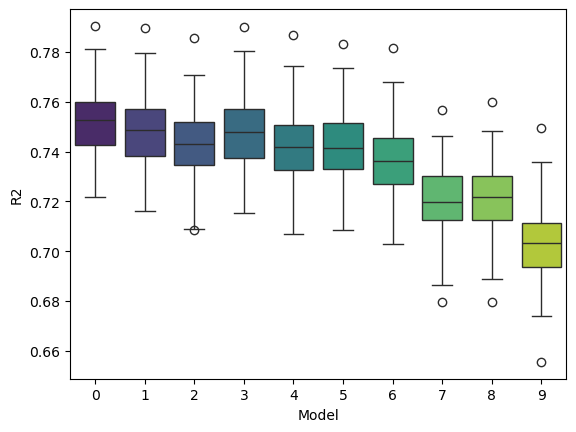

In [356]:
plt.clf()
# Parallel boxplot to compare
sns.boxplot(x='Model',y='R2',data=results,palette='viridis')
plt.show()


### Variable transformations

We apply the best transformations to the numeric dependent variables. To simplify, we will remove effects that are not beneficial and also exclude sqft_above (due to collinearity issues) from the set of variables considered for transformation.

In [359]:
cols_to_drop = ['bedrooms_cat', 'sqft_above', 'prop_missings', 'random', 'random2']
num_vars = imput.drop(cols_to_drop, axis=1).select_dtypes(include=np.number)

# Aplicar transformaciones
transf_cor = num_vars.apply(lambda x: mejorTransf(x, varObjCont_log, tipo='cor'))

# Obtener nombres de transformadas
transf_cor_names = num_vars.apply(lambda x: mejorTransf(x, varObjCont_log, tipo='cor', name=True))

# Asignar nombres
transf_cor.columns = transf_cor_names.values

transf_cor.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month_sqr            4999 non-null   float64
 1   bathrooms_sqr        4999 non-null   float64
 2   sqft_living_ident    4999 non-null   float64
 3   yr_built_cuarta      4999 non-null   float64
 4   lat_raiz4            4999 non-null   float64
 5   long_exp             4999 non-null   float64
 6   bedrooms_cont_ident  4999 non-null   float64
 7   log_sqft_lot_sqr     4999 non-null   float64
dtypes: float64(8)
memory usage: 312.6 KB


Here are the transformations that the function has made in the variables that we have picked. sqft_living_ident hasn't been transformed. 

I'll grab these transformations and will add them to the dataset for the automatic selection process

In [361]:
# Input with transformed variables according to correlation
imput_transf_cor = imput.drop(['bedrooms_cat',
                              'sqft_above','prop_missings','random','random2'],axis=1).join(transf_cor)#.reset_index(drop=True)
imput_transf_cor.info()
data_transf = imput_transf_cor.join(varObjCont_log)#.reset_index(drop=True))
data_transf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4998
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   month                4999 non-null   float64 
 1   bathrooms            4999 non-null   float64 
 2   sqft_living          4999 non-null   float64 
 3   yr_built             4999 non-null   float64 
 4   lat                  4999 non-null   float64 
 5   long                 4999 non-null   float64 
 6   bedrooms_cont        4999 non-null   float64 
 7   log_sqft_lot         4999 non-null   float64 
 8   year                 4999 non-null   category
 9   floors               4999 non-null   category
 10  waterfront           4999 non-null   category
 11  view                 4999 non-null   category
 12  condition            4999 non-null   category
 13  basement             4999 non-null   category
 14  yr_renovated         4999 non-null   category
 15  lat_rec              4999 

### Variable Automatic Selection

In [363]:
# Apply the full model formula
form = ols_formula(data_transf, 'log_price')
form

# Generate design matrices according to the full model formula
y, X_transf = patsy.dmatrices(form, data_transf, return_type='dataframe')


We are now going to test classic variable selection methods that, starting from the full or null model, will sequentially remove or add variables until reaching a specified number of variables or until achieving the best score or greatest parsimony.

In [365]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

clf = LinearRegression()

# Convert y from DataFrame to 1D array
y_1d = y.values.ravel()

# Build step backward feature selection
sfs_back = sfs(
    clf,
    k_features='parsimonious',  # o un número como 5 o 10 si prefieres
    forward=False,
    floating=False,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Fit SFFS
sfs_back = sfs_back.fit(X_transf, y_1d)

# Print selected feature names
print(sfs_back.k_feature_names_)

# Print cross-validated score of the selected subset
print(sfs_back.k_score_)


('year[T.2015]', 'waterfront[T.1]', 'view[T.1]', 'condition[T.B]', 'lat_rec[T.[47.51, inf)]', 'bathrooms', 'yr_built', 'sqft_living_ident', 'yr_built_cuarta', 'lat_raiz4')
0.7473343251797105


### Visualization of the variable selection process

It doesn’t seem like the model improves much, reaching at most around 0.76 in R²...



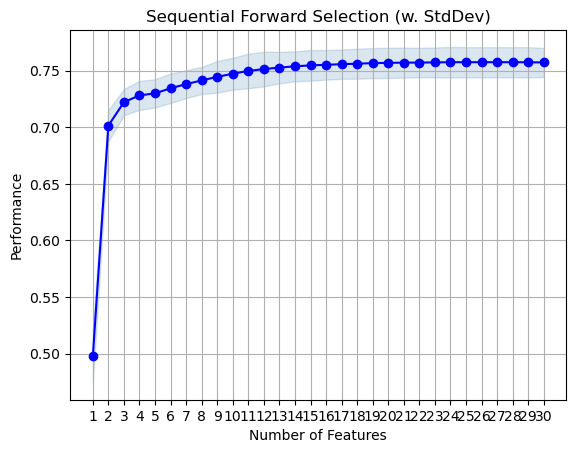

In [367]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_back.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()


We can see in the graph above that the model doesn't improve too much when it reaches 14 variables. I'll run a more parsimonious model based on that:

In [369]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

clf = LinearRegression()

# Convertir y a 1D array
y_1d = y.values.ravel()

# SFS hacia adelante con parsimonia
sfs_forw = sfs(
    clf, 
    k_features='parsimonious', 
    forward=True, 
    floating=False, 
    scoring='r2',
    cv=5,
    n_jobs=-1
)

sfs_forw = sfs_forw.fit(X_transf, y_1d)

print('\nSequential Forward Selection:')
print('Selected features:', sfs_forw.k_feature_names_)
print('Cross-validated R² score:', sfs_forw.k_score_)



Sequential Forward Selection:
Selected features: ('year[T.2015]', 'floors[T.1.5]', 'waterfront[T.1]', 'view[T.1]', 'condition[T.B]', 'condition[T.Unknown]', 'basement[T.1]', 'yr_renovated[T.1]', 'lat_rec[T.[47.51, inf)]', 'bathrooms', 'sqft_living', 'yr_built', 'long', 'bedrooms_cont', 'yr_built_cuarta', 'lat_raiz4', 'long_exp', 'log_sqft_lot_sqr')
Cross-validated R² score: 0.7560068552569267
